# Designing `pycbc_inference` workflow generator for batch of events

>>> **ALGORITHM**

>> **Requirements**:
 1. Take as input **multiple** `sampler.ini`:
     - Each can have different samplers configured
 1. Take as input **multiple** `inference.ini` with options for the `pycbc_inference` jobs.
     - Each `inference.ini` can use different sampling priors and `model`s,
 1. Take as input **one** `config.ini` with configuration options for the workflow
     - Specifies which events to run with as a list
     - Specifies what sample rate to use for each event
     - Specifies how much data (=32 or 4096 secs) should be downloaded for each event
     - 
     - Specifies which `sampler???.ini` to use
     - Specifies which `inference???.ini` to use
     - Each subset of events will have a full set of operations,
     - A new directory structure is created as:
         - `${ROOT}/eventNNNNNN/` ...


>>> **Outline**:
 1. Read in `config.ini` and parse it. 
 1. Say the user asks for `N` events, `S` different samplers, and `M` different inferencing combinations. We have a total of `N x S x M` independent runs.
 1. **Create** subdirs `event???` for each of the `N` physically distinct events.
 1. **Create** `S` subdirs of each of those for each sampler type
 1. **Create** `M` subdirs of each of those for each model / prior set
 1. Run directory for each event is `event???/sampler???/model???`
 1. **Copy** over the relevant `sampler.ini` and `inference???.ini` as `inference.ini`
 1. **Write** the relevant `data.ini` for each event in `event???/sampler???/model???`
 1. **Write** run script for running `pycbc_inference` on it. Call it `run_inference.sh`.
 1. Create `1` `BaseJob`s PER event + inference combination. First is the `inference` job, second is the `post_processing` job. Make the former a parent job.
 1. Add both jobs as nodes to the `DAG`
 1. **SUBMIT** the `DAG` to chosen scheduler: condor or slurm;
      - All jobs at once? : of course!
      - Do we check if an analysis is running? : yes, for the `DAG` only though!
      - Do we resume? Or, do we kill and restart all forcefully? (BAD IDEA)
          - Is `pycbc_inference` able to resume **correctly** yet?


**NOTE**: Steps`9-11` assume `Condor`! Upgrade to use `Slurm` later.

>> **Implementation**:
 1. `DAG` managed through `glue`,
 2. `CondorJob` managed through `BaseJob`,
 3. Way to define variables in equivalent representation,
 

>>> **Technical**
 1. Directory structure for all jobs ... ?

## Imports and setup

In [1]:
import os
import sys
import shutil
import glob
import h5py
import subprocess

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex = True)

plt.rcParams.update(  # try to match font sizes of document
  {'axes.labelsize': 20,
   'axes.titlesize': 20,
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': True,
   'font.family': 'serif',
   'font.serif': ['palatino'],
   'savefig.dpi': 300
   })

%pylab inline

from glue.ligolw import ligolw
from glue.ligolw import table
from glue.ligolw import lsctables
from glue.ligolw import ilwd
from glue.ligolw import utils as ligolw_utils

import pycbc.strain
import pycbc.psd
from pycbc.pnutils import mass1_mass2_to_mchirp_eta
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_two_pol_waveform_filter, get_td_waveform
from pycbc import DYN_RANGE_FAC
from pycbc.types import FrequencySeries, zeros
from pycbc.filter import match, overlap, sigma, make_frequency_series
from pycbc.scheme import CPUScheme, CUDAScheme
from pycbc import pnutils
from pycbc import frame

import gwnr
from gwnr.Utils.SupportFunctions import make_padded_frequency_series
from gwnr.DataAnalysis import get_unique_hex_tag
import gwnr.DataAnalysis as DA

sys.path.append('/home/prayush.kumar/src/gwnrtools/bin/')
sys.path.append('/home/prayush/src/gwnrtools/bin/')
#sys.path.append('/home/prayush.kumar/local/venv/pycbc_master_enigma/src/gwnrtools/bin/')

Populating the interactive namespace from numpy and matplotlib


/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
run_dir = '/home/prayush/research/test_pycbc_event2'
try: os.makedirs(run_dir)
except: pass
os.chdir(run_dir)

In [3]:
!ls 

config.ini  eve.ini	   inference.ini  inj.ini  sampler2.ini
data.ini    eventGW150914  injection.ini  log	   sampler.ini


## Fetching GWOSC data

In [4]:
gwnr.DataAnalysis.catalog_events

[u'GW151012',
 u'GW170608',
 u'GW170729',
 u'GW150914',
 u'GW151226',
 u'GW170814',
 u'GW170817',
 u'GW170104',
 u'GW170809',
 u'GW170818',
 u'GW170823']

In [5]:
m = gwnr.DataAnalysis.Merger('GW150914')

In [ ]:
!pwd
!ls -lh . *

In [8]:
filename = m.fetch_data('H1', 32, 4096, 'data')

In [9]:
!pwd
!ls -lh . *

/home/prayush/research/test_pycbc_event2
.:
total 4.0K
drwxr-xr-x 2 prayush prayush 4.0K Mar  2 16:17 data

data:
total 126M
-rw------- 1 prayush prayush  125M Mar  2 16:00 H-H1_GWOSC_4KHZ_R1-1126257415-4096.gwf
-rw------- 1 prayush prayush 1006K Mar  2 16:17 H-H1_GWOSC_4KHZ_R1-1126259447-32.gwf


In [10]:
m.channel_name('H1', 4096)

'H1:GWOSC-4KHZ_R1_STRAIN'

In [11]:
print(filename)

data/H-H1_GWOSC_4KHZ_R1-1126259447-32.gwf


In [12]:
fr = frame.read_frame(filename, m.channel_name('H1', 4096))

/home/prayush/local/venv/pycbc_inf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


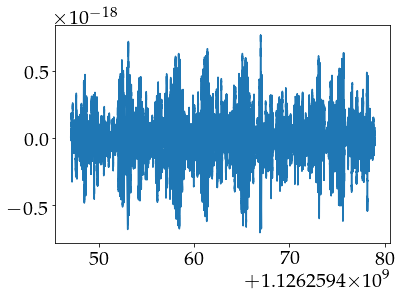

In [13]:
plot(fr.sample_times, fr)

## Code

In [ ]:
import gwnr

In [ ]:
reload(gwnr)

In [ ]:
gwnr.Stats.InferenceConfigs?

In [ ]:
x = gwnr.Stats.InferenceConfigs('.')

In [ ]:
x.available_configs()

In [ ]:
sy = x.get_config_writer('sampler')

In [ ]:
sy.types()

In [ ]:
sy.write('emcee_pt_v1')

In [ ]:
!ls

In [ ]:
!cat sampler.ini

In [ ]:
dy = x.config_writers['data']

In [ ]:
dy.names()

In [ ]:
dy.write

In [ ]:
!rm emcee_pt_v1

In [ ]:
confs.get('workflow', 'sampler').split()

In [ ]:
from six.moves import configparser as ConfigParser

In [ ]:
sampler_configs = {}
for f in confs.get('workflow', 'sampler').split():
    sampler_configs[f] = ConfigParser.ConfigParser()
    sampler_configs[f].read(f)

In [ ]:
!cat sampler.ini

In [ ]:
cp = sampler_configs['sampler2.ini']

In [ ]:
cp.sections()

In [ ]:
for s in cp.sections():
    print(s)
    print(cp.items(s))

In [ ]:
confs.items('executables')

In [ ]:
confs.items('inspinj')

In [ ]:
confs.set('inspinj', 'seed', '1234')

In [ ]:
def test_local_dir_change():
    idir = os.getcwd()
    print(idir)
    os.chdir('/home/prayush/research/')
    print(os.getcwd())    
    os.chdir(idir)

In [ ]:
test_local_dir_change()

In [ ]:
np.random.randint(10, 10000)

In [ ]:
os.getcwd()

In [ ]:
'data.ini'.split('.ini')[0]

In [ ]:
import itertools

In [ ]:
for p in itertools.product(['data.ini', 'data2.ini'], ['sampler.ini', 'sampler2.ini'], ['model.ini']):
    print(p)

In [ ]:
list(itertools.product(['data.ini', 'data2.ini'], ['sampler.ini', 'sampler2.ini'], ['model.ini']))

In [ ]:
len('')

In [ ]:
confs['x'], confs['y'], confs['z'] = ['data.ini', 'data2.ini', 'data3.ini']

In [ ]:
confs.items('executables')

In [ ]:
with open('data.ini', 'r') as d:
    x = d.read()

In [ ]:
with open('/home/prayush/test.ini', 'w') as f:
    f.write(x)

In [ ]:
!git diff --no-index data.ini /home/prayush/test.ini

## Workflow generator

In [4]:
from glue.pipeline import CondorDAGJob, CondorDAGNode, CondorDAG, CondorJob

In [4]:
!pwd

/home/prayush/research/test_pycbc_event2


In [5]:
os.chdir(run_dir)

In [6]:
!ls

config.ini  eve.ini	   injection.ini  sampler2.ini
data.ini    inference.ini  inj.ini	  sampler.ini


In [13]:
# Write CONFIGS

# data.ini
with open("data.ini", "w") as fout:
    fout.write("""\
[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be provided, so we'll
; just make one up
channel-name = H1:STRAIN L1:STRAIN
; Providing an injection file will cause a simulated
; signal to be added to the data
injection-file = injection.hdf
; We'll use a high-pass filter so as not to get numerical errors from the large
; amplitude low frequency noise. Here we use 15 Hz, which is safely below the
; low frequency cutoff of our likelihood integral (20 Hz)
strain-high-pass = 15
; The pad-data argument is for the high-pass filter: 8s are added to the
; beginning/end of the analysis/psd times when the data is loaded. After the
; high pass filter is applied, the additional time is discarded. This pad is
; *in addition to* the time added to the analysis start/end time for the PSD
; inverse length. Since it is discarded before the data is transformed for the
; likelihood integral, it has little affect on the run time.
pad-data = 8
""")
    

# sampler.ini
with open("sampler.ini", "w") as fout:
    fout.write("""\
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;      SAMPLER
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
[sampler]
name = emcee_pt
nwalkers = 200
ntemps = 20
effective-nsamples = 1000
checkpoint-interval = 2000
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior

;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;   Sampling transforms
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
""")

subprocess.call(['cp', '-v', 'sampler.ini', 'sampler2.ini'])

# inference.ini
with open("inference.ini", "w") as fout:
    fout.write("""\
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;   Model
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
[model]
name = gaussian_noise
low-frequency-cutoff = 20.0


;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;   Sampling parameters
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
[variable_params]
; waveform parameters that will vary in MCMC
delta_tc =
mass1 =
mass2 =
spin1_a =
spin1_azimuthal =
spin1_polar =
spin2_a =
spin2_azimuthal =
spin2_polar =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =

[static_params]
; waveform parameters that will not change in MCMC
approximant = IMRPhenomPv2
f_lower = 20
f_ref = 20
; we'll set the tc by using the trigger time in the data
; section of the config file + delta_tc
trigger_time = ${data|trigger-time}

;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;   Sampling priors
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
[prior-delta_tc]
; coalescence time prior
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
; we need to provide tc to the waveform generator
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-mass2]
name = uniform
min-mass2 = 10.
max-mass2 = 80.

[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0.0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[prior-distance]
; following gives a uniform volume prior
name = uniform_radius
min-distance = 10
max-distance = 1000

[prior-coa_phase]
; coalescence phase prior
name = uniform_angle

[prior-inclination]
; inclination prior
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-polarization]
; polarization prior
name = uniform_angle
""")

# Workflow.ini
with open("config.ini", "w") as fout:
    fout.write("""\
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
;   Executables                                                                 
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
[executables]                                                                   
inspinj = ${which:pycbc_create_injections}                                      
inference = ${which:pycbc_inference}                                            
plot = ${which:pycbc_inference_plot_posterior}                                  
                                                                                
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
;   Workflow                                                                    
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
[workflow]                                                                      
accounting-group = ligo.dev.o3.cbc.explore.test                                 
templates-per-job = 100                                                         
log-path = log                                                                  
inference-request-memory = 20G                                                  
inference-request-cpus = 10                                                     
data = data.ini                                                                 
sampler = sampler.ini sampler2.ini                                              
inference = inference.ini                                                       
events = GW150914                                                               
data-sample-rate = 4096                                                         
data-duration = 32                                                              
                                                                                
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
;   Inference                                                                   
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
[inference]                                                                     
verbose =                                                                       
seed = 12                                                                       
config-files = inference.ini data.ini sampler.ini                               
output-file = inference.hdf                                                     
nprocesses = 10                                                                 
force =                                                                         
                                                                                
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
;   Visualize                                                                   
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;                                            
[plot]                                                                          
input-file = inference.hdf                                                      
output-file = plots/posteriors.png                                              
plot-scatter =                                                                  
plot-marginal =                                                                 
plot-prior = inference.ini data.ini                                             
                                                                                
[plot-1]                                                                        
output-file = plots/posteriors1.png                                             
                                                                                
[plot-2]                                                                        
output-file = plots/posteriors2.png                                             
                                                                                
[plot-3]                                                                        
output-file = plots/posteriors3.png
""")

In [10]:
!cat injection.ini
!cat data.ini
!cat sampler.ini
!cat inference.ini
!cat config.ini

[static_params]
tc = 1126259462.420
;mass1 = 37
mass2 = 32
ra = 2.2
dec = -1.25
inclination = 2.5
coa_phase = 1.5
polarization = 1.75
distance = 100
f_ref = 20
f_lower = 18
approximant = ENIGMA
taper = start

[variable_params]
mass1 =
eccentricity =
mean_per_ano =

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-eccentricity]
name = uniform
min-eccentricity = 0.
max-eccentricity = 0.2

[prior-mean_per_ano]
name = uniform
min-mean_per_ano = 0.
max-mean_per_ano = 3.1416
[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be prov

In [23]:
!/home/prayush/src/gwnrtools/bin/gwnr_create_public_events_inference_workflow -h

usage: /home/prayush/src/GWNRTools/bin/gwnrtools_create_public_events_inference_workflow [--options]

Setup workflow to perform Bayesian parameter estimation runs on a custom set
of public gravitational-wave events using open data

optional arguments:
  -h, --help            show this help message and exit
  --version             Prints version information.
  --verbose             Print logging messages.
  --output-dir OUTPUT_DIR
                        Output directory path.
  --force               If the output-dir already exists, overwrite it.
                        Otherwise, an OSError is raised.
  --do-not-fetch-data   Don't fetch GWOSC data.
  --nprocesses NPROCESSES
                        Number of processes to use. If not given then only a
                        single core will be used.
  --use-mpi             Use MPI to parallelize the sampler
  --seed SEED           Seed to use for the random number generator that
                        initially distributes the walkers

In [4]:
run -i /home/prayush/src/gwnrtools/bin/gwnr_create_public_events_inference_workflow --verbose --config-file=config.ini --force

2020-03-10 23:24:22,365 Reading configuration file
2020-03-10 23:24:22,367 Using seed 0
2020-03-10 23:24:22,369 Running with CPU support: 1 threads
2020-03-10 23:24:22,483 Reading configuration file
2020-03-10 23:24:22,486 Will setup analyses in /home/prayush/research/test_pycbc_event2
2020-03-10 23:24:22,487 Making workspace directories
2020-03-10 23:24:22,489 Creating DAG
2020-03-10 23:24:22,496 Making eventGW150914/sampler2/inference in /home/prayush/research/test_pycbc_event2
2020-03-10 23:24:22,567 Copying config files to eventGW150914/sampler2/inference
2020-03-10 23:24:22,569 Copying executables to eventGW150914/sampler2/inference/scripts/


2020-03-10 23:24:25,554 Making eventGW150914/sampler/inference in /home/prayush/research/test_pycbc_event2
2020-03-10 23:24:25,628 Copying config files to eventGW150914/sampler/inference
2020-03-10 23:24:25,630 Copying executables to eventGW150914/sampler/inference/scripts/


2020-03-10 23:24:28,221 Done


In [7]:
confs.get_subsections('plot')

['1', '2', '3']

In [13]:
confs.items('plot')

[('input-file', 'inference.hdf'),
 ('plot-scatter', ''),
 ('plot-marginal', ''),
 ('plot-prior', 'inference.ini data.ini')]

In [14]:
confs.items('plot-1')

[('output-file', 'plots/posteriors1.png')]

In [17]:
l1 = confs.items('plot')
l1.extend(confs.items('plot-1'))

In [18]:
l1

[('input-file', 'inference.hdf'),
 ('plot-scatter', ''),
 ('plot-marginal', ''),
 ('plot-prior', 'inference.ini data.ini'),
 ('output-file', 'plots/posteriors1.png')]

In [13]:
for sec in confs.sections():
    if sec[:4] == 'plot':
        print sec

plot


In [ ]:
'SEOBNRv4' in td_approximants()

In [ ]:
# DATA.INI
with open("data.ini", "w") as fout:
    fout.write("""\
[data]
instruments = H1 L1
trigger-time = 1126259462.42
analysis-start-time = -6
analysis-end-time = 2
; strain settings
sample-rate = 2048
fake-strain = H1:aLIGOaLIGODesignSensitivityT1800044 L1:aLIGOaLIGODesignSensitivityT1800044
fake-strain-seed = H1:44 L1:45
; psd settings
psd-estimation = median-mean
psd-inverse-length = 8
psd-segment-length = 8
psd-segment-stride = 4
psd-start-time = -256
psd-end-time = 256
; even though we're making fake strain, the strain
; module requires a channel to be provided, so we'll
; just make one up
channel-name = H1:STRAIN L1:STRAIN
; Providing an injection file will cause a simulated
; signal to be added to the data
injection-file = injection.hdf
; We'll use a high-pass filter so as not to get numerical errors from the large
; amplitude low frequency noise. Here we use 15 Hz, which is safely below the
; low frequency cutoff of our likelihood integral (20 Hz)
strain-high-pass = 15
; The pad-data argument is for the high-pass filter: 8s are added to the
; beginning/end of the analysis/psd times when the data is loaded. After the
; high pass filter is applied, the additional time is discarded. This pad is
; *in addition to* the time added to the analysis start/end time for the PSD
; inverse length. Since it is discarded before the data is transformed for the
; likelihood integral, it has little affect on the run time.
pad-data = 8
""")

In [ ]:
!cat data.ini

In [ ]:
# emcee_pt-gw150914_like
with open("emcee_pt-gw150914_like.ini", "w") as fout:
    fout.write("""\
[sampler]
name = emcee_pt
nwalkers = 200
ntemps = 20
effective-nsamples = 1000
checkpoint-interval = 2000
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = nacl & max_posterior

;
;   Sampling transforms
;
[sampling_params]
; parameters on the left will be sampled in
; parametes on the right
mass1, mass2 : mchirp, q

[sampling_transforms-mchirp+q]
; inputs mass1, mass2
; outputs mchirp, q
name = mass1_mass2_to_mchirp_q
""")

In [ ]:
!cat emcee_pt-gw150914_like.ini

In [ ]:
# gw150914_like
with open("gw150914_like.ini", "w") as fout:
    fout.write("""\
[model]
name = gaussian_noise
low-frequency-cutoff = 20.0

[variable_params]
; waveform parameters that will vary in MCMC
delta_tc =
mass1 =
mass2 =
spin1_a =
spin1_azimuthal =
spin1_polar =
spin2_a =
spin2_azimuthal =
spin2_polar =
distance =
coa_phase =
inclination =
polarization =
ra =
dec =

[static_params]
; waveform parameters that will not change in MCMC
approximant = ENIGMA
f_lower = 20
f_ref = 20
; we'll set the tc by using the trigger time in the data
; section of the config file + delta_tc
trigger_time = ${data|trigger-time}

[prior-delta_tc]
; coalescence time prior
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
; we need to provide tc to the waveform generator
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

[prior-mass1]
name = uniform
min-mass1 = 10.
max-mass1 = 80.

[prior-mass2]
name = uniform
min-mass2 = 10.
max-mass2 = 80.

[prior-spin1_a]
name = uniform
min-spin1_a = 0.0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0.0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[prior-distance]
; following gives a uniform volume prior
name = uniform_radius
min-distance = 10
max-distance = 1000

[prior-coa_phase]
; coalescence phase prior
name = uniform_angle

[prior-inclination]
; inclination prior
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-polarization]
; polarization prior
name = uniform_angle
""")

In [ ]:
!cat gw150914_like.ini

In [ ]:
# RUN.SH
with open("run.sh", "w") as fout:
    fout.write("""#!/bin/sh

# sampler parameters
PRIOR_CONFIG=gw150914_like.ini
DATA_CONFIG=data.ini
SAMPLER_CONFIG=emcee_pt-gw150914_like.ini
OUTPUT_PATH=inference.hdf

# the following sets the number of cores to use; adjust as needed to
# your computer's capabilities
NPROCS=10

# run sampler
# Running with OMP_NUM_THREADS=1 stops lalsimulation
# from spawning multiple jobs that would otherwise be used
# by pycbc_inference and cause a reduced runtime.
OMP_NUM_THREADS=1 \
pycbc_inference --verbose \
    --seed 12 \
    --config-file ${PRIOR_CONFIG} ${DATA_CONFIG} ${SAMPLER_CONFIG} \
    --output-file ${OUTPUT_PATH} \
    --nprocesses ${NPROCS} \
    --force
""")

In [ ]:
!cat run.sh